# Programatically understand Gaussian Processes: Part 1

### An example

![](20d-conditional-main.gif)

Let us look at the GIF above. It shows a non-linear fit with uncertainty on a set of points in the 2d space. The uncertainty is shown by the gray shadowed region. The animation shows how the fit and the uncertainty varies as we keep adding more points (shown as big circles). As expected, as more points are added, the uncertainty of the fit in the vicinity of the added points reduces. This is an example of Gaussian Processes (GP) regression in play.

### Introduction

There exist some great online resources for Gaussian Processes (GPs) including an excellent recent [Distill.Pub article](https://www.jgoertler.com/visual-exploration-gaussian-processes/). This blog post is an attempt with a programatic flavour. In this notebook, we will build the intuition and learn some basics of GPs. This notebook is heavily inspired by the awesome tutorial by Richard Turner. Here is the link to the [slides](http://cbl.eng.cam.ac.uk/pub/Public/Turner/News/imperial-gp-tutorial.pdf) and [video](https://www.youtube.com/watch?v=92-98SYOdlY)

### Some imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

### A function to make the Matplotlib plots prettier

In [2]:
SPINE_COLOR = 'gray'

def format_axes(ax):
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

    for spine in ['left', 'bottom']:
        ax.spines[spine].set_color(SPINE_COLOR)
        ax.spines[spine].set_linewidth(0.5)

    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_tick_params(direction='out', color=SPINE_COLOR)

    return ax

### One dimensional Gaussian/Normal

We will start the discussion with 1d Gaussians. Let us write some simple code to generate/sample data from $\mathcal{N}(\mu=0, \sigma=1)$

In [3]:
one_dim_normal_data = np.random.normal(0, 1, size=10000)

Let us now visualise the data in a 1d space using scatter plot

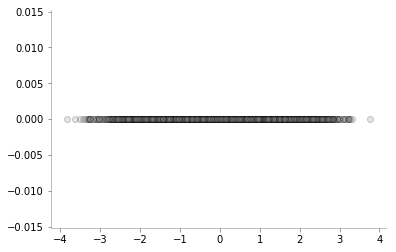

In [4]:
plt.scatter(one_dim_normal_data, np.zeros_like(one_dim_normal_data), alpha=0.2, c='gray', edgecolors='k', marker='o')
format_axes(plt.gca())

As we would expect, there are a lot of samples close to zero (mean) and as we go further away from zero, the number of samples keeps reducing. We can also visualise the same phenomenon using a normed histogram shown below.

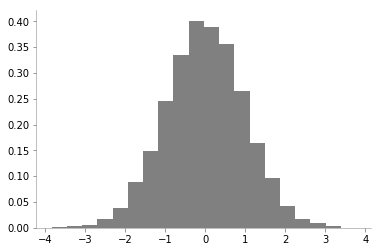

In [5]:
plt.hist(one_dim_normal_data, density=True, bins=20, color='gray')
format_axes(plt.gca())

We can notice that there is a high probability of drawing samples close to the mean and the probability is low far from the mean.

However, since histograms come with their own set of [caveats](https://jakevdp.github.io/PythonDataScienceHandbook/05.13-kernel-density-estimation.html), let us use kernel desnity estimation for obtaining the probability density of 1d Gaussian.

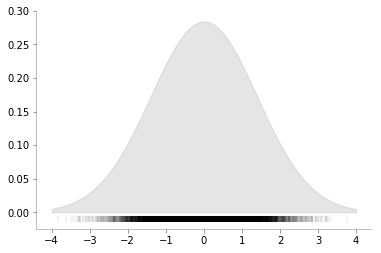

In [6]:
from sklearn.neighbors import KernelDensity

x_d = np.linspace(-4, 4, 100)

# instantiate and fit the KDE model
kde = KernelDensity(bandwidth=1.0, kernel='gaussian')
kde.fit(one_dim_normal_data[:, None])

# score_samples returns the log of the probability density
logprob = kde.score_samples(x_d[:, None])

plt.fill_between(x_d, np.exp(logprob), alpha=0.2, color='gray')
plt.plot(one_dim_normal_data, np.full_like(one_dim_normal_data, -0.01), '|k', markeredgewidth=0.1)
format_axes(plt.gca())

We can now see a smoother version of the histogram and can again verify the properties of 1D Gaussian. Let us now vary the variance of 1D Gaussian and make the same plots to enhance our understanding of the concept.

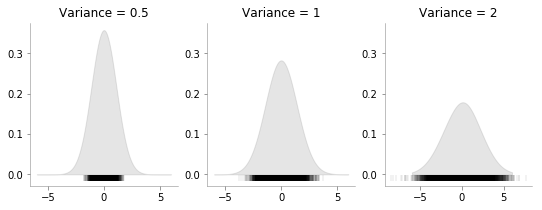

In [7]:
fig, ax = plt.subplots(ncols=3, sharey=True, figsize=(9, 3))
x_d = np.linspace(-6, 6, 400)

for i, var in enumerate([0.5, 1, 2]):
    one_dim_normal_data = np.random.normal(0, var, size=10000)
    kde = KernelDensity(bandwidth=1.0, kernel='gaussian')
    kde.fit(one_dim_normal_data[:, None])

    # score_samples returns the log of the probability density
    logprob = kde.score_samples(x_d[:, None])

    ax[i].fill_between(x_d, np.exp(logprob), alpha=0.2, color='gray')
    ax[i].plot(one_dim_normal_data, np.full_like(one_dim_normal_data, -0.01), '|k', markeredgewidth=0.1)
    format_axes(ax[i])
    ax[i].set_title(f"Variance = {var}")

We can see that how increasing the variance makes the data more spread.

### Bi-variate Gaussian

Having discussed the case of 1d Gaussian, now let us move to multivariate Gaussians. As a special case, let us first consider bi-variate or 2d Gaussian. It's parameters are the mean vector which will have 2 elements and a covariance matrix.

We can write the distribution as:
$$
\begin{pmatrix}
 X_1 \\
 X_2
\end{pmatrix}  \sim \mathcal{N} \left( \begin{pmatrix}
 \mu_1 \\
 \mu_2
\end{pmatrix} , \begin{pmatrix}
 a & \rho \\
 \rho & b
\end{pmatrix} \right)
$$


where $\mu_1$, $\mu_2$ are the means for $X_1$ and $X_2$ respectively; $a$ is the standard deviation for $X_1$, $b$ is the standard deviation for $X_2$ and $\rho$ is the correlation between $X_1$ and $X_2$

Let us now draw some data from: 
$$
\begin{pmatrix}
 X_1 \\
 X_2
\end{pmatrix}  \sim \mathcal{N} \left( \begin{pmatrix}
 0 \\
 0
\end{pmatrix} , \begin{pmatrix}
 1 & 0.7 \\
 0.7 & 1
\end{pmatrix} \right)
$$


In [8]:
data = np.random.multivariate_normal(mean = np.array([0, 0]), cov = np.array([[1, 0.7], [0.7, 1]]), size=(10000, ))

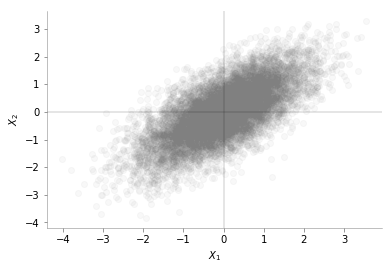

In [9]:
plt.scatter(data[:, 0], data[:, 1], alpha=0.05,c='gray')
plt.axhline(0, color='k', lw=0.2)
plt.axvline(0, color='k', lw=0.2)
plt.xlabel(r"$X_1$")
plt.ylabel(r"$X_2$")

format_axes(plt.gca())

We can see from the plot above that the data is distributed around mean [0, 0]. We can also see the positive correlation between $X_1$ and $X_2$

### Marginalisation for bivariate Gaussian

Let us look into an interesting plot provided by Seaborn. 

In [10]:
import pandas as pd
data_df = pd.DataFrame(data, columns=[r'$X_1$',r'$X_2$'])

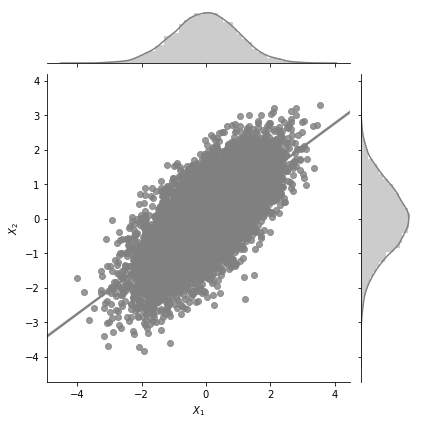

In [11]:
import seaborn as sns
g = sns.jointplot(x= r'$X_1$', y=r'$X_2$', data=data_df, kind="reg",color='gray')

The central plot is exactly the same as the scatter plot we made earlier. But, we see two additional 1d KDE plots at the top and the right. What do these tell us? These tell us the marginal 1d distributions of $X_1$ and $X_2$.


The marginal distribution of $X_1$ is the distribution of $X_1$ considering all values of $X_2$ and vice versa. One of the interesting properties of Gaussian distributions is that the marginal distribution of a Gaussian is also a Gaussian distribution. MathematicalMonk on Youtube has a [great set of lectures on this topic](https://www.youtube.com/watch?v=ycDSJkZ_h0I) that I would highly recommend!

What would you expect the marginal distribution of $X_1$ to look like? No prizes for guessing.

Given 
$$
\begin{pmatrix}
 X_1 \\
 X_2
\end{pmatrix}  \sim \mathcal{N} \left( \begin{pmatrix}
 \mu_1 \\
 \mu_2
\end{pmatrix} , \begin{pmatrix}
 a & \rho \\
 \rho & b
\end{pmatrix} \right)
$$

we have the marginal distribution of:
$$X_1 \sim \mathcal{N}(\mu_1, a)$$
and 
$$X_2 \sim \mathcal{N}(\mu_2, b)$$


In [12]:
def plot_jointplot_2d(a, b, rho):
    data = np.random.multivariate_normal(mean = np.array([0, 0]), cov = np.array([[a, rho], [rho, b]]), size=(10000, ))
    data_df = pd.DataFrame(data, columns=[r'$X_1$',r'$X_2$'])
    g = sns.jointplot(x= r'$X_1$', y=r'$X_2$', data=data_df, kind="reg",color='gray')

Ok, let us know try to plot a few jointplots for different covariance matrices. We would be passing in the values of $a$, $b$ and $\rho$ which would make up the covariance matrix as: 
\begin{pmatrix}
 a & \rho \\
 \rho & b
\end{pmatrix}


We would make these plots for mean zero.

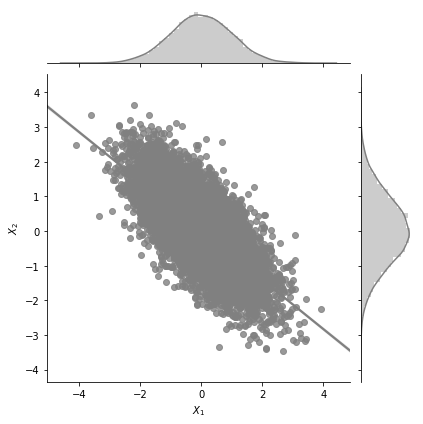

In [13]:
plot_jointplot_2d(1, 1, -0.7)

In the plot above, for $a=1$, $b=1$ and $\rho=0.7$ we can see the negative correlation (but high) between $X_1$ and $X_2$. 

Let us now increase the variance in $X_1$ and keep all other paramaters constant.

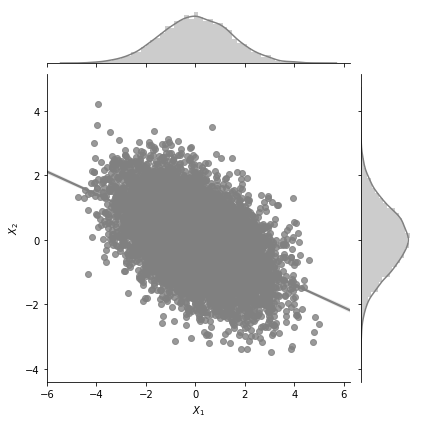

In [14]:
plot_jointplot_2d(2, 1, -0.7)

One can see from the plot above that the variance in $X_1$ is much higher now and the plot extends from -6 to +6 for $X_1$ while earlier it was restricted from -4 to 4.

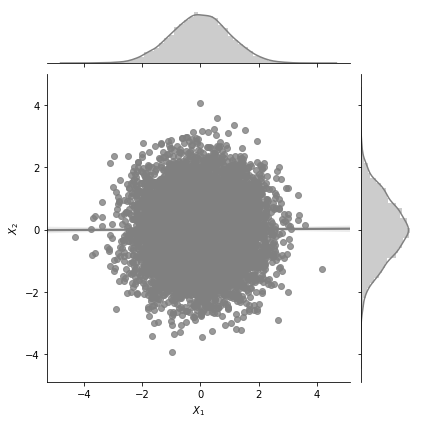

In [15]:
plot_jointplot_2d(1, 1, 0.0)

One can see from the plot above that the correlation between $X_1$ and $X_2$ is zero.

#### Surface plots for bi-variate Gaussian

We will now look into surface plots for bi-variate Gaussian. This is yet another way to plot and understand Gaussian distributions. I borrow code from an [excellent tuorial](https://scipython.com/blog/visualizing-the-bivariate-gaussian-distribution/) on plotting bivariate Gaussians.

In [16]:
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm


def make_pdf_2d_gaussian(mu, sigma):
    N = 60
    X = np.linspace(-3, 3, N)
    Y = np.linspace(-3, 4, N)
    X, Y = np.meshgrid(X, Y)

    # Pack X and Y into a single 3-dimensional array
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X
    pos[:, :, 1] = Y

    F = multivariate_normal(mu, sigma)
    Z = F.pdf(pos)



    # Create a surface plot and projected filled contour plot under it.
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_surface(X, Y, Z, rstride=3, cstride=3, linewidth=1, antialiased=True,
                    cmap=cm.Greys)
    
    ax.set_xlabel(r"$X_1$")
    ax.set_ylabel(r"$X_2$")
    ax.set_zlabel("PDF")

    cset = ax.contourf(X, Y, Z, zdir='z', offset=-0.15, cmap=cm.Greys)

    # Adjust the limits, ticks and view angle
    ax.set_zlim(-0.15,0.25)
    ax.set_zticks(np.linspace(0,0.2,5))
    ax.view_init(27, -15)
    ax.set_title(f'$\mu$ = {mu}\n $\Sigma$ = {sigma}')

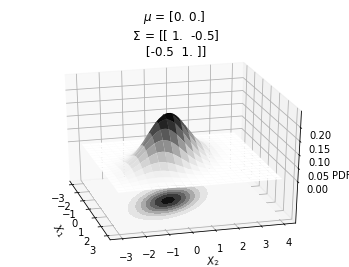

In [17]:
mu = np.array([0., 0.])
sigma = np.array([[ 1. , -0.5], [-0.5,  1]])

make_pdf_2d_gaussian(mu, sigma)

From the plot above, we can see the surface plot showing the probability density function for the Gaussian with mean \begin{pmatrix}
 0 \\
 0
\end{pmatrix} and covariance matrix: \begin{pmatrix}
 1 & -0.5 \\
 -0.5 & 1
\end{pmatrix}

It can be seen that the probability peaks arounds $X_1=0$ and $X_2=0$. The bottom plot shows the same concept using contour plots which we will heavily use from now on. The different circles in the bottom contour plot denote the loci of same probability density. Since the contour plot requires a lesser dimension, it will be easier to use in our further analysis.

Also, from the contour plots, we can see the correlation between $X_1$ and $X_2$.

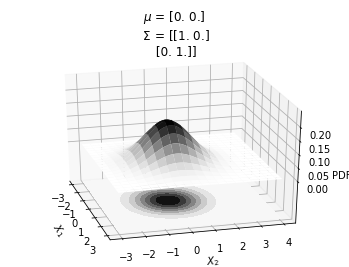

In [18]:
mu = np.array([0., 0.])
sigma = np.array([[ 1. , 0], [0,  1]])

make_pdf_2d_gaussian(mu, sigma)

In the plot above, we can see that $X_1$ and $X_2$ are not correlated.

#### Contour plots for 2D Gaussians

Having seen the relationship between the surface plots and the contour plots, we will now exclusively focus on the contour plots. Here is a simple function to generate the contour plot for 2g gaussian with mean and covariance as the arguments.

In [19]:
def plot_2d_contour_pdf(mu, sigma):
    X = np.linspace(-3, 3, 60)
    Y = np.linspace(-3, 4, 60)
    X, Y = np.meshgrid(X, Y)

    # Pack X and Y into a single 3-dimensional array
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X
    pos[:, :, 1] = Y

    F = multivariate_normal(mu, sigma)
    Z = F.pdf(pos)
    plt.xlabel(r"$X_1$")
    plt.ylabel(r"$X_2$")
    
    plt.title(f'$\mu$ = {mu}\n $\Sigma$ = {sigma}')
    plt.contourf(X, Y, Z, zdir='z', offset=-0.15, cmap=cm.Greys)
    plt.colorbar()
    format_axes(plt.gca())

/home/nipunbatra-pc/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'zdir', 'offset'
  s)


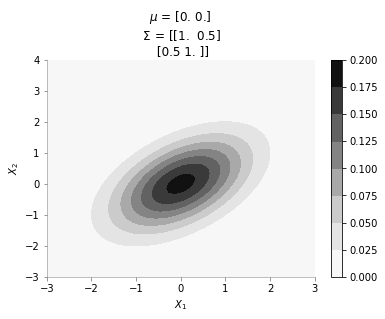

In [20]:
mu = np.array([0., 0.])
sigma = np.array([[ 1. , 0.5], [0.5,  1.]])
plot_2d_contour_pdf(mu, sigma)

The plot above shows the contour plot for 2d gaussian with mean [0, 0] and covariance [[ 1. , 0.5], [0.5,  1.]]. We can see the correlation between $X_1$ and $X_2$

### Sample from 2d gaussian and visualising it on XY plane

We will now sample a point from a 2d Gaussian and describe a new way of visualising it.

![](images/0.7/0.jpg)

* The left most plot shows the covariance matrix. 

* The middle plot shows the contour plot. The dark point marked in the contour plot is a sampled point (at random) from this 2d Gaussian distribution. 

* The right most plot is an alternative representation of the sampled point. The x-axis corresponds to the labels $X_1$ and $X_2$ and the corresponding y-axis are the coordinates of the point in the $X_1$, $X_2$ dimension shown in the contour plot. 

We will now write a function to generate a random sample from a 2d gaussian given it's mean and covariance matrix.

In [21]:
def plot_2d_contour_pdf_dimensions(mu, sigma, random_num):
    fig, ax  = plt.subplots(ncols=3, figsize=(12, 4))

    X = np.linspace(-3, 3, 60)
    Y = np.linspace(-3, 3, 60)
    X, Y = np.meshgrid(X, Y)

    # Pack X and Y into a single 3-dimensional array
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X
    pos[:, :, 1] = Y

    F = multivariate_normal(mu, sigma)
    Z = F.pdf(pos)
    random_point = F.rvs(random_state=random_num)
    
    sns.heatmap(sigma, ax=ax[0], annot=True)
    ax[1].contour(X, Y, Z, cmap=cm.Greys)
    ax[1].scatter(random_point[0], random_point[1], color='k',s=100)
    ax[1].set_xlabel(r"$X_1$")
    ax[1].set_ylabel(r"$X_2$")
    
    data_array = pd.Series(random_point, index=['X1','X2'])
    data_array.plot(ax=ax[2], kind='line', marker='o',color='k')
    plt.xticks(np.arange(len(data_array.index)), data_array.index.values)
    ax[2].set_ylim(-3, 3)
    
    format_axes(ax[0])
    format_axes(ax[1])
    format_axes(ax[2])
    ax[0].set_title("Covariance Matrix")
    ax[1].set_title("Contour of pdf")
    ax[2].set_title("Visualising the point")
    plt.suptitle(f"Random state = {random_num}", y=1.1)
    plt.tight_layout()
    import os
    if not os.path.exists("images"):
        os.makedirs("images")
    if not os.path.exists(f"images/{sigma[0, 1]}"):
        os.makedirs(f"images/{sigma[0, 1]}")
    plt.savefig(f"images/{sigma[0, 1]}/{random_num}.jpg", bbox_inches="tight")
    plt.close()

We will now create 20 such samples and animate them 

In [22]:
for i in range(20):
    plot_2d_contour_pdf_dimensions( mu, np.array([[ 1. , 0.1], [0.1,  1.]]), i)

In [23]:
!convert -delay 20 -loop 0 images/0.1/*.jpg sigma-0-1.gif

![](sigma-0-1.gif)

Since the correlation between the two variables $X_1$ and $X_2$ was low (0.1), we can the see that rightmost plot jumping a lot, i.e. to say that the values of $X_1$ and $X_2$ are not tighly constrained to move together.

In [24]:
for i in range(20):
    plot_2d_contour_pdf_dimensions( mu, np.array([[ 1. , 0.7], [0.7,  1.]]), i)

In [25]:
!convert -delay 20 -loop 0 images/0.7/*.jpg sigma-0-7.gif

![](sigma-0-7.gif)

The above GIF shows the same plot/animation for the 2d Gaussian where the correlation between the two variables is high (0.7). Thus, we can see that the two variables tend to move up and down together.

### Conditional Bivariate Distribution

All excellent till now. Now, let us move to the case in which some variable's values are known. We would then look to find the distribution of the other variables conditional on the value of the known variable. I borrow some text from Wikipedia on the subject.

$$
\begin{pmatrix}
 X_1 \\
 X_2
\end{pmatrix}  \sim \mathcal{N} \left( \begin{pmatrix}
 0 \\
 0
\end{pmatrix} , \begin{pmatrix}
 1 & \rho \\
 \rho & 1
\end{pmatrix} \right)
$$

The conditional expectation of $X_2$ given $X_1$ is: $\operatorname{E}(X_2 \mid X_1=x_1)= \rho x_1 $

and the conditional variance is: $\operatorname{var}(X_2 \mid X_1 = x_1) = 1-\rho^2$ 

So, the question now is: suppose we fix $X_1 = 1$, what is the distribution of $X_2$. Again, Gaussians are amazing - the conditional distributionon is again a Gaussian. Let us make some plots to understand better. The following plots would be showing the distribution of $X_2$ with fixed $X_1$

In [26]:
def plot_2d_contour_pdf_dimensions_fixed_x1(sigma, random_num, x1 = 1):
    mu = np.zeros(2)
    fig, ax  = plt.subplots(ncols=3, figsize=(12, 4))

    X = np.linspace(-3, 3, 60)
    Y = np.linspace(-3, 3, 60)
    X, Y = np.meshgrid(X, Y)

    # Pack X and Y into a single 3-dimensional array
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X
    pos[:, :, 1] = Y

    F = multivariate_normal(mu, sigma)
    Z = F.pdf(pos)
    
    rho = sigma[0, 1]
    F_cond_x1 = multivariate_normal(rho*x1, 1-rho**2)
    random_point_x2 = F_cond_x1.rvs(random_state=random_num)
    sns.heatmap(sigma, ax=ax[0], annot=True)
    ax[1].contour(X, Y, Z, cmap=cm.Greys)
    ax[1].scatter(x1, random_point_x2, color='k',s=100)
    ax[1].set_xlabel(r"$X_1$")
    ax[1].set_ylabel(r"$X_2$")
    
    data_array = pd.Series([x1, random_point_x2], index=['X1','X2'])
    data_array.plot(ax=ax[2], kind='line', color='k')
    ax[2].scatter(x=0, y=x1, color='red', s=100)
    ax[2].scatter(x=1, y=random_point_x2, color='k', s=100)
    

    plt.xticks(np.arange(len(data_array.index)), data_array.index.values)
    ax[2].set_ylim(-3, 3)
    format_axes(ax[0])
    format_axes(ax[1])
    format_axes(ax[2])
    ax[0].set_title("Covariance Matrix")
    ax[1].set_title("Contour of pdf")
    ax[2].set_title("Visualising the point")
    plt.suptitle(f"Random state = {random_num}", y=1.1)
    plt.tight_layout()
    import os
    if not os.path.exists("images/conditional/"):
        os.makedirs("images/conditional/")
    if not os.path.exists(f"images/conditional/{sigma[0, 1]}"):
        os.makedirs(f"images/conditional/{sigma[0, 1]}")
    plt.savefig(f"images/conditional/{sigma[0, 1]}/{random_num}.jpg", bbox_inches="tight")
    plt.close()

In [27]:
for i in range(20):
    plot_2d_contour_pdf_dimensions_fixed_x1(np.array([[ 1. , 0.1], [0.1,  1.]]), i)

In [28]:
!convert -delay 20 -loop 0 images/conditional/0.1/*.jpg conditional-sigma-0-1.gif

![](conditional-sigma-0-1.gif)

The above animation shows the movement of $X_2$ with $X_1=1$. The $X_1=1$ is shown in red in the righmost plot. In the middle plot, we can confirm that the movement is only in the $X_2$ dimension. Further, since the correlation between $X_1$ and $X_2$ is weak, the righmost plot seems to wiggle or jump a lot!

In [29]:
for i in range(20):
    plot_2d_contour_pdf_dimensions_fixed_x1(np.array([[ 1. , 0.7], [0.7,  1.]]), i)

In [30]:
!convert -delay 20 -loop 0 images/conditional/0.7/*.jpg conditional-sigma-0-7.gif

![](conditional-sigma-0-7.gif)

In the plot above, we repeat the same p|rocedure but with a covariance matrix having a much higher correlation between $X_1$ and $X_2$. From the righmost plot, we can clearly see that the jumps in $X2$ are far lesser. This is expected, since the two variables are correlated!

#### Visualising the same procedure for 5 dimensional Gaussian

We will now repeat the same procedure we did for 2d case in 5 dimensions. 

In [31]:
covariance_5d = np.array([[1, 0.9, 0.8, 0.6, 0.4],
                          [0.9, 1, 0.9, 0.8, 0.6],
                          [0.8, 0.9, 1, 0.9, 0.8],
                          [0.6, 0.8, 0.9, 1, 0.9],
                          [0.4, 0.6, 0.8, 0.9, 1]])

In [32]:
def plot_5d_contour_pdf_dimensions(cov, random_num):
    fig, ax  = plt.subplots(ncols=2, figsize=(6, 3))

    mu = np.zeros(5)
    F = multivariate_normal(mu, cov)
    random_point = F.rvs(random_state=random_num)
    
    sns.heatmap(cov, ax=ax[0], annot=True)
    
    
    data_array = pd.Series(random_point, index=['X1','X2','X3','X4', 'X5'])
    data_array.plot(ax=ax[1], kind='line', marker='o',color='k')
    plt.xticks(np.arange(len(data_array.index)), data_array.index.values)
    ax[1].set_ylim(-3, 3)
    for i in range(2):
        format_axes(ax[i])
    
    ax[0].set_title("Covariance Matrix")
    ax[-1].set_title("Visualising the point")
    plt.suptitle(f"Random state = {random_num}", y=1.1)
    plt.tight_layout()
    import os
    if not os.path.exists("images/5d/"):
        os.makedirs("images/5d")
    
    plt.savefig(f"images/5d/{random_num}.jpg", bbox_inches="tight")
    plt.close()

In [33]:
plot_5d_contour_pdf_dimensions(covariance_5d, 2)

In [34]:
for i in range(20):
    plot_5d_contour_pdf_dimensions(covariance_5d, i)

In [35]:
!convert -delay 20 -loop 0 images/5d/*.jpg 5d.gif

![](5d.gif)

From the visualisation above we can see that:
    
* since X1 and X2 are highly correlated, they move up and down together
* but, X1 and X5 have low correlation, thus, they can seem to wiggle almost independently of each other.

We are now getting somewhere. If the correlation between the variables is very high, we will get a smooth curve joining them. Right? Almost getting to the point where we can draw the introductory plot shown at the top of the post.

### Conditional Multivariate Distribution

Ok, now let us draw the conditional distribution over this higher 5d space. We will fix the values of some of the variables and see the distribution of the others.

Borrowing from Wikipedia

If $N$-dimensional $x$ is partitioned as follows

$$
\mathbf{x}
=
\begin{bmatrix}
 \mathbf{x}_A \\
 \mathbf{x}_B
\end{bmatrix}
\text{ with sizes }\begin{bmatrix} q \times 1 \\ (N-q) \times 1 \end{bmatrix}
$$

and accordingly $μ$ and $Σ$ are partitioned as follows

$$
\boldsymbol\mu
=
\begin{bmatrix}
 \boldsymbol\mu_A \\
 \boldsymbol\mu_B
\end{bmatrix}
\text{ with sizes }\begin{bmatrix} q \times 1 \\ (N-q) \times 1 \end{bmatrix}
$$

$$
\boldsymbol\Sigma
=
\begin{bmatrix}
 \boldsymbol\Sigma_{AA} & \boldsymbol\Sigma_{AB} \\
 \boldsymbol\Sigma_{BA} & \boldsymbol\Sigma_{BB}
\end{bmatrix}
\text{ with sizes }\begin{bmatrix} q \times q & q \times (N-q) \\ (N-q) \times q & (N-q) \times (N-q) \end{bmatrix}
$$

then the distribution of $x_A$ conditional on $x_B=b$ is multivariate normal $(x_A|x_B=b)\sim \mathcal{N}(\bar{\mu}, \bar{\Sigma})$

$$
\bar{\boldsymbol\mu}
=
\boldsymbol\mu_A + \boldsymbol\Sigma_{AB} \boldsymbol\Sigma_{BB}^{-1}
\left(
 \mathbf{B} - \boldsymbol\mu_B
\right)
$$

and covariance matrix

$$
\overline{\boldsymbol\Sigma}
=
\boldsymbol\Sigma_{AA} - \boldsymbol\Sigma_{AB} \boldsymbol\Sigma_{BB}^{-1} \boldsymbol\Sigma_{BA}.
$$

Let us for our example take $X_5 = -2$. 

We have:

$x_A = [x_1, x_2, x_3, x_4]$ and $x_B = [x_5]$

Assuming the covariance matrix of size 5 X 5 is referred as $C$

$$
\boldsymbol\Sigma_{AA}
=
\begin{bmatrix}
 C_{11} & C_{12} & C_{13} & C_{14}\\
 C_{21} & C_{22} & C_{23} & C_{24}\\
 C_{31} & C_{32} & C_{33} & C_{34}\\
 C_{41} & C_{42} & C_{43} & C_{44}\\
\end{bmatrix} \\
$$

$$
\boldsymbol\Sigma_{AB}
=
\begin{bmatrix}
 C_{15}\\
 C_{25}\\
 C_{35}\\
 C_{45}\\
\end{bmatrix}
$$

$$
\boldsymbol\Sigma_{BA}
=
\begin{bmatrix}
 C_{51}& C_{52} & C_{53} & C_{54}\\
\end{bmatrix}
$$

$$
\boldsymbol\Sigma_{BB}
=
\begin{bmatrix}
 C_{55}\\
\end{bmatrix}
$$

Putting in the numbers we get:
    

In [36]:
sigma_AA = covariance_5d[:4, :4]

In [37]:
sigma_AA

array([[1. , 0.9, 0.8, 0.6],
       [0.9, 1. , 0.9, 0.8],
       [0.8, 0.9, 1. , 0.9],
       [0.6, 0.8, 0.9, 1. ]])

In [38]:
sigma_AB = covariance_5d[:4, 4].reshape(-1, 1)

In [39]:
sigma_AB

array([[0.4],
       [0.6],
       [0.8],
       [0.9]])

In [40]:
sigma_BA = covariance_5d[4, :4].reshape(1, -1)

In [41]:
sigma_BA

array([[0.4, 0.6, 0.8, 0.9]])

In [42]:
sigma_BB = covariance_5d[4, 4].reshape(-1, 1)

In [43]:
sigma_BB

array([[1.]])

Now, calculating $\bar{\mu}$

In [44]:
mu_bar = np.zeros((4, 1)) + sigma_AB@np.linalg.inv(sigma_BB)*(-2)

In [45]:
mu_bar

array([[-0.8],
       [-1.2],
       [-1.6],
       [-1.8]])

Since, $x_5$ has highest correlation with $x_4$ it makes sense for $x_5=-2$ to have the mean of $x_4$ to be close to -2.

Now, calculating $\bar{\Sigma}$

In [46]:
sigma_bar = sigma_AA - sigma_AB@np.linalg.inv(sigma_BB)@sigma_BA

In [47]:
sigma_bar

array([[0.84, 0.66, 0.48, 0.24],
       [0.66, 0.64, 0.42, 0.26],
       [0.48, 0.42, 0.36, 0.18],
       [0.24, 0.26, 0.18, 0.19]])

Now, we have the new mean and covariance matrices for $x_A = [x_1, x_2, x_3, x_4]$ and $x_B = [x_5] = [-2]$. Let us now draw some samples fixing $x_5 = -2$

In [48]:
cov = sigma_bar
mu = mu_bar.flatten()
def plot_5d_samples_fixed_x2(random_num):
    fig, ax  = plt.subplots(ncols=2, figsize=(6, 3))
    
    
    F = multivariate_normal(mu, cov)
    
    sns.heatmap(cov, ax=ax[0], annot=True)
    random_point = F.rvs(random_state=random_num)
    
    
    data_array = pd.Series(random_point, index=['X1','X2','X3','X4'])
    data_array['X5'] = -2
    data_array.plot(ax=ax[1], kind='line', marker='.',color='k')
    plt.scatter([4], [-2], color='red', s=100)
    plt.xticks(np.arange(len(data_array.index)), data_array.index.values)
    ax[1].set_ylim(-3, 3)
    for i in range(2):
        format_axes(ax[i])
    
    ax[0].set_title("Covariance Matrix")
    ax[-1].set_title("Visualising the point")
    plt.suptitle(f"Random state = {random_num}", y=1.1)
    plt.tight_layout()
    import os
    if not os.path.exists("images/5d/conditional/1"):
        os.makedirs("images/5d/conditional/1")
    
    plt.savefig(f"images/5d/conditional/1/{random_num}.jpg", bbox_inches="tight")
    plt.close()
    

In [49]:
for i in range(20):
    plot_5d_samples_fixed_x2(i)

In [50]:
!convert -delay 20 -loop 0 images/5d/conditional/1/*.jpg 5d-conditional-1.gif

![](5d-conditional-1.gif)

### Let's increase to 20 dimensions now!

We can not surely write the covariance matrix for 20 dimensions. Let us use a small trick called the kernel function to create this matrix. We will come it later. For now, let us think of this function as a function which:

* outputs low numbers for $x_1$ and $x_2$ if they differ by a lot
* outputs high number for $x_1$ and $x_2$ if they are very close

In [51]:
def rbf_kernel(x_1, x_2, sig):
    return np.exp((-(x_1-x_2)**2)/2*(sig**2))

In [52]:
rbf_kernel(1, 1, 0.4)

1.0

Since 1=1, the above function evaluates to 1 showing that 1 is similar to 1

In [53]:
rbf_kernel(1, 2, 0.4)

0.9231163463866358

Since 1 and 2 are close, the function above evaluates to close to 1

In [54]:
rbf_kernel(1, 2, 1)

0.6065306597126334

Ok, we use the same first two arguments 1 and 2 but change the last one to 1 from 0.4 and we see that the function evaluates to a much smaller number. Thus, we can see that increase the `sig` parameter leads to quicker dropoff in similarity between pair of points. Or, in other words, higher `sig` means that the influence of a point `x_1` reduces quicker.

Let us now create the covariance matrix of size (20, 20) using this kernel function.

In [55]:
C = np.zeros((20, 20))

In [56]:
for i in range(20):
    for j in range(20):
        C[i, j] = rbf_kernel(i, j, 0.5)

Let us plot the heatmap of the covariance matrix

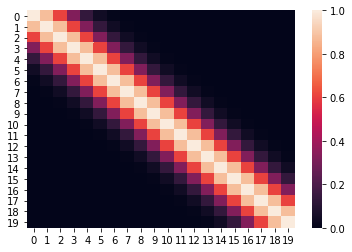

In [57]:
sns.heatmap(C)

The above heatmap confirms that there is correlation between nearby points, but close to zero or zero correlation otherwise.

#### Let us draw some samples from this 20 dimensional Gaussian

In [58]:
def plot_20d_samples(random_num):
    fig, ax  = plt.subplots(figsize=(10, 3))
    
    
    F = multivariate_normal(np.zeros(20), C)
    random_point = F.rvs(random_state=random_num)
    index = [f'X{i}' for i in range(1, 21)]
    data_array = pd.Series(random_point, index=index)
    data_array.plot(ax=ax, kind='line', marker='.',color='k')
    plt.xticks(np.arange(len(data_array.index)), data_array.index.values)
    
    plt.suptitle(f"Random state = {random_num}", y=1.1)
    plt.tight_layout()
    import os
    if not os.path.exists("images/20d/"):
        os.makedirs("images/20d/")
    
    plt.ylim(-3, 3)
    plt.savefig(f"images/20d/{random_num}.jpg", bbox_inches="tight")
    plt.close()

In [59]:
for i in range(50):
    plot_20d_samples(i)

In [60]:
!convert -delay 20 -loop 0 images/20d/*.jpg 20d.gif

![](20d.gif)

From the animation above, we can see different family of functions of mean zero across these 20 points. We're really getting close now!

#### Let us now condition on a few elements 

We will create a new ordering of these variables such that the known variables occur towards the end. This allows for easy calculations for conditioning.

In [61]:
order = [2, 3, 4, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 0, 1, 5, 10]

In [62]:
new_C = np.zeros_like(C)

In [63]:
old_order = range(20)

In [64]:
for i in range(20):
    for j in range(20):
        new_C[i, j] = C[order[i], order[j]]

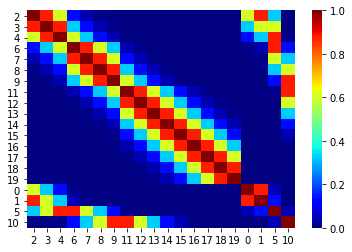

In [65]:
sns.heatmap(new_C, xticklabels=order, yticklabels=order, cmap='jet')

Now, we can condition on (x1 = 1, x2 = 3, x6 = -3, X11 = 1). We will use the same procedure we used above in the case of 5d.

In [66]:
B = np.array([1, 3, -3, 1]).reshape(-1, 1)
B

array([[ 1],
       [ 3],
       [-3],
       [ 1]])

In [67]:
sigma_AA_20d = new_C[:-B.size, :-B.size]
sigma_AA_20d.shape

(16, 16)

In [68]:
sigma_BB_20d = new_C[-B.size:, -B.size:]
sigma_BB_20d.shape

(4, 4)

In [69]:
sigma_AB_20d = new_C[:-B.size, -B.size:]
sigma_AB_20d.shape

(16, 4)

In [70]:
sigma_BA_20d = new_C[-B.size:, :-B.size]
sigma_BA_20d.shape

(4, 16)

In [71]:
mu_bar_20d = np.zeros((20-B.size, 1)) + sigma_AB_20d@np.linalg.inv(sigma_BB_20d)@(B)

In [72]:
sigma_bar_20d = sigma_AA_20d - sigma_AB_20d@np.linalg.inv(sigma_BB_20d)@sigma_BA_20d

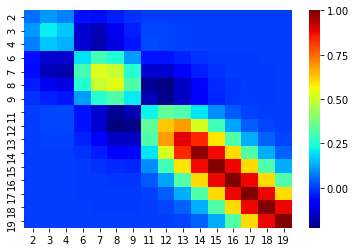

In [73]:
sns.heatmap(sigma_bar_20d, xticklabels=order[:-B.size], yticklabels=order[:-B.size], cmap='jet')

In [74]:
def plot_20d_samples_known_x(random_num):
    fig, ax  = plt.subplots(figsize=(10, 3))
    
    
    F = multivariate_normal(mu_bar_20d.flatten(), sigma_bar_20d)
    random_point = F.rvs(random_state=random_num)
    index = [f'X{i+1}' for i in order[:-B.size]]
    data_array = pd.Series(random_point, index=index)
    data_array['X1'] = 1
    data_array['X2'] = 3
    data_array['X6'] = -3
    data_array['X11'] = -1
    
    data_array = data_array[[f'X{i+1}' for i in range(20)]]
    data_array.plot(ax=ax, kind='line', marker='.',color='k')
    plt.xticks(np.arange(len(data_array.index)), data_array.index.values)
    plt.scatter([0, 1,5, 10], [1, 3, -3, -1], color='red',s=100)

    plt.suptitle(f"Random state = {random_num}", y=1.1)
    plt.tight_layout()
    import os
    if not os.path.exists("images/20d/conditional/"):
        os.makedirs("images/20d/conditional/")
    plt.grid()
    plt.ylim(-4, 4)
    plt.savefig(f"images/20d/conditional/{random_num}.jpg", bbox_inches="tight")
    plt.close()

In [75]:
for i in range(50):
    plot_20d_samples_known_x(i)

In [76]:
!convert -delay 20 -loop 0 images/20d/conditional/*.jpg 20d-conditional.gif

![](20d-conditional.gif)

From the plot above, we can see the known points in red and the other points wiggle to show the families of functions that we fit. Let us now draw a lot of samples and plot the mean and variance in these samples for the unknown X variables. We could have obtained the mean and variance directly using Gaussian marginalisation, but, for now let us just draw many samples.

In [77]:
F = multivariate_normal(mu_bar_20d.flatten(), sigma_bar_20d)
dfs = {}
for random_num in range(100):
    random_point = F.rvs(random_state=random_num)
    index = [f'X{i+1}' for i in order[:-B.size]]
    data_array = pd.Series(random_point, index=index)
    data_array['X1'] = 1
    data_array['X2'] = 3
    data_array['X6'] = -3
    data_array['X11'] = -1
    
    data_array = data_array[[f'X{i+1}' for i in range(20)]]
    dfs[random_num] = data_array


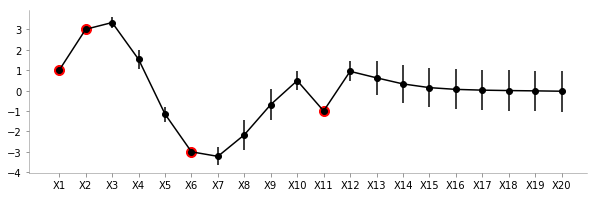

In [78]:
fig, ax = plt.subplots(figsize=(10, 3))
pd.DataFrame(dfs).mean(axis=1).plot(yerr=pd.DataFrame(dfs).std(axis=1),marker='o', color='k')
plt.xticks(np.arange(len(data_array.index)), data_array.index.values)
plt.scatter([0, 1,5, 10], [1, 3, -3, -1], color='red',s=100)
format_axes(plt.gca())

From the plot above, we can see the uncertainty (standard deviation) and the mean values for different variables. As expected, the uncertainty close to the known points (red) is low. Also, owing to the smooth nature of the covariance function we can see the means of unknown points close to known points are fairly similar.

To summarise: We can very clearly see that there is low variance in zones where we have the known values and high variance otherwise. The farther we go away from a known value, the more is the variance!

### Kernels!

We will now take a small plunge into the world of kernels. As mentioned earlier, we will limit the discussion to generating to covariance matrix.

We will be redefining the function mentioned above to include two parameters `l` and `s`

* `s` is the scale of variance
* `l` is the influence of the point to neighbouring points

In [79]:
def sig(x1, x2, l, s):
    return s**2*(np.exp((-1/2*(l**2))*((x1-x2)**2)))

In [80]:
Cov_matrix = np.zeros((100, 100))

Text(0.5, 0.98, 'Covariance matrix for varying l and s = 1')

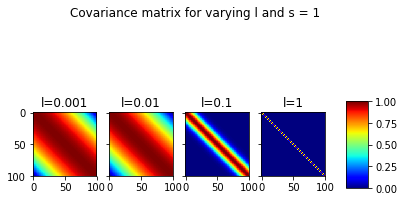

In [81]:
fig, ax = plt.subplots(ncols=4, sharex=True, sharey=True)
s = 1
for ix, l in enumerate([0.001, 0.01, 0.1, 1]):
    for i in range(100):
        for j in range(100):
            Cov_matrix[i, j] = sig(i, j, l, 1)
    im = ax[ix].imshow(Cov_matrix, cmap='jet')
    ax[ix].set_title(f"l={l}")
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.35, 0.05, 0.3])
fig.colorbar(im, cax=cbar_ax)
plt.suptitle(f"Covariance matrix for varying l and s = {s}")

In the plot above, we can the covariance matrices for fixed `s=1` and varying `l`. It can be seen that for very low `l`, the correlations between far away points is also significant. At `l=1`, this ceases to be the case.

Text(0.5, 0.98, 'Covariance matrix for varying s and l = 0.1')

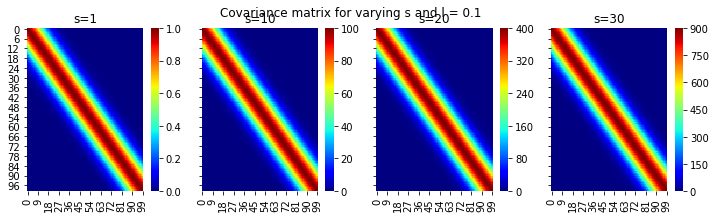

In [82]:
fig, ax = plt.subplots(ncols=4, sharex=True, sharey=True, figsize=(12, 3))
for ix, s in enumerate([1, 10, 20, 30]):
    for i in range(100):
        for j in range(100):
            Cov_matrix[i, j] = sig(i, j, 0.1, s)
    sns.heatmap(Cov_matrix, cmap='jet', ax=ax[ix])
    ax[ix].set_title(f"s={s}")
plt.suptitle("Covariance matrix for varying s and l = 0.1")

Ok, this is great. We can see the different scales on the colorbars with increasing `s` and fixing `l`

Now, let us try and redo the 20 point dataset with varying kernel parameters with conditioning on some known data.

In [83]:
def fit_plot_gp(kernel_s, kernel_l, known_data, total_data_points, save=False):
    """
    kernel_s: sigma^2 param of kernel
    kernel_l: l (width) param of kernel
    known_data: {pos: value}
    total_data_points
    """
    o = list(range(20))
    for key in known_data.keys():
        o.remove(key)
    o.extend(list(known_data.keys()))
    
    C = np.zeros((total_data_points, total_data_points))
    for i in range(total_data_points):
        for j in range(total_data_points):
            C[i, j] = sig(i, j, kernel_l, kernel_s)
        
    
    # Making known variables shift
    new_C = np.zeros_like(C)
    for i in range(20):
        for j in range(20):
            new_C[i, j] = C[o[i], o[j]]
    B = np.array(list(known_data.values())).reshape(-1, 1)    
    sigma_BA_20d = new_C[-B.size:, :-B.size]
    sigma_AB_20d = new_C[:-B.size, -B.size:]
    sigma_BB_20d = new_C[-B.size:, -B.size:]
    sigma_AA_20d = new_C[:-B.size, :-B.size]

    mu_bar_20d = np.zeros((20-B.size, 1)) + sigma_AB_20d@np.linalg.inv(sigma_BB_20d)@(B)
    sigma_bar_20d = sigma_AA_20d - sigma_AB_20d@np.linalg.inv(sigma_BB_20d)@sigma_BA_20d
    F = multivariate_normal(mu_bar_20d.flatten(), sigma_bar_20d)
    dfs = {}
    for random_num in range(100):
        random_point = F.rvs(random_state=random_num)
        index = [f'X{i+1}' for i in o[:-B.size]]
        data_array = pd.Series(random_point, index=index)
        for k, v in known_data.items():
            data_array[f'X{k+1}'] = v
        

        data_array = data_array[[f'X{i+1}' for i in range(20)]]
        dfs[random_num] = data_array
    fig, ax = plt.subplots(figsize=(10, 3))
    mean_vector = pd.DataFrame(dfs).mean(axis=1)
    mean_vector.plot(marker='.', color='k')
    yerr=pd.DataFrame(dfs).std(axis=1)
    
    plt.fill_between(range(len(mean_vector)), mean_vector+yerr, mean_vector-yerr, color='gray',alpha=0.4)
    plt.xticks(np.arange(len(data_array.index)), data_array.index.values)
    plt.scatter(list(known_data.keys()), list(known_data.values()), color='gray',s=200,zorder=1)
    format_axes(plt.gca())
    plt.title(f" l = {kernel_l} and s = {kernel_s}")
    import os
    if save:
        if not os.path.exists("images/20d/conditional-points/"):
            os.makedirs("images/20d/conditional-points/")
        plt.grid()
        plt.xticks(np.arange(len(data_array.index)), np.arange(len(data_array.index)))
        plt.ylim(-4, 4)
        plt.title(f"Known data: {known_data}")
        plt.savefig(f"images/20d/conditional-points/{len(known_data.keys())}.jpg", bbox_inches="tight")
        plt.close()
        

In [84]:
known_d = {0:-2, 1:3, 9:-1, 14:-1}

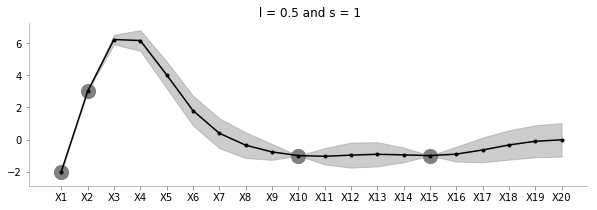

In [85]:
fit_plot_gp(1, 0.5, known_d, 20)

The above plot shows the uncertainty and the family of functions for `l=0.5` and `s=1`. 

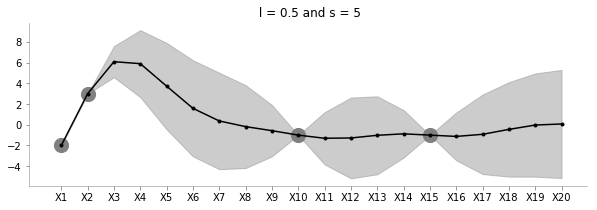

In [86]:
fit_plot_gp(5, 0.5, known_d, 20)

Keeping `l=0.5`, the above plot shows how increasing `s` increases the uncertainty of estimation.

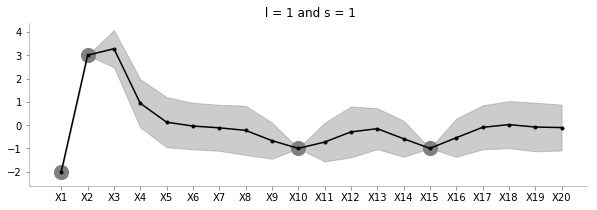

In [87]:
fit_plot_gp(1, 1, known_d, 20)

The above plot shows how increasing `l` reduces the influence between far away points.

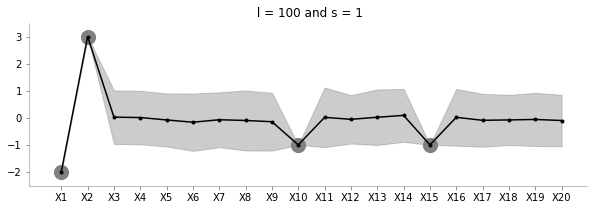

In [88]:
fit_plot_gp(1, 100, known_d, 20)

The above plot increases `l` to a very large value. Seems to be just moving around the mean?

In [89]:
np.random.seed(0)
order_points_added = np.random.choice(range(20), size=9, replace=False)
k = {}
for i in range(9):
    k[order_points_added[i]] = np.random.choice(range(-3, 3))
    fit_plot_gp(1, 0.5, k, 20, True)

In [90]:
!convert -delay 40 -loop 0 images/20d/conditional-points/*.jpg 20d-conditional-main.gif

Let us create a small animation where we keep on adding points and see how the uncertainty and estimation changes

![](20d-conditional-main.gif)

There you go! This ends the first part of this tutorial. In the next part, we will talk about kernels in detail!